# Force Optimizations Data Analysis 

In [1]:
from optimization_tools import *
from analysis_tools import *
import matplotlib.pyplot as plt

## Ensemble of Optimizations

First, we perform our initial optimizations using the random (educated) guesses for the weights on the objective function.

In [2]:
# initial_optimizations()

We can obtain DataFrames for the original, filtered, and Pareto data with this statement. 

(This also exports the Universally Unique Identifiers (UUIDs) of the Pareto front to `pareto.txt`). 

In [4]:
df, df_filtered, df_pareto = get_dfs()
# df, df_filtered, df_pareto = get_dfs(inputs="./tests/*/results.json") # REMOVE LATER

Let's take a look at our optimizations!

/var/folders/_6/q5y1g_5d74j18s1hfz6jhj2h0000gn/T/ipykernel_20847/1380173541.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pareto_plt(df, df_filtered, df_pareto).show()


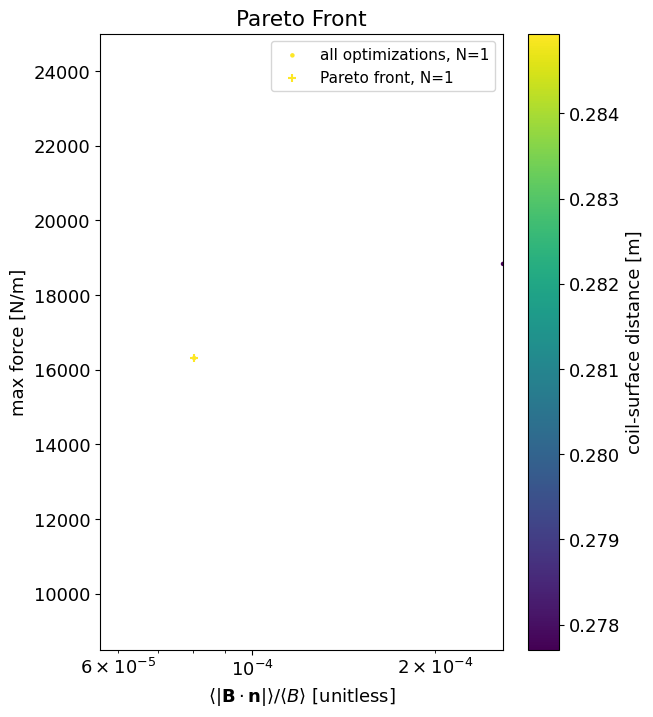

In [5]:
pareto_plt(df, df_filtered, df_pareto).show()

Here, we use Pearson's R to examine the correlations between the maximum force and parameters that were outputted by the optimizations.

In [6]:
print(parameter_correlations(df_filtered, sort_by="max_max_force").to_markdown())

|    | Parameter             |   R |   P |
|---:|:----------------------|----:|----:|
| 10 | cs_weight             |   1 |   0 |
| 14 | max_max_κ             |   1 |   0 |
|  2 | length_weight         |   1 |   0 |
| 18 | coil_coil_distance    |   1 |   0 |
|  9 | cs_threshold          |   1 |   0 |
| 16 | max_max_force         |   1 |   0 |
| 11 | force_threshold       |   1 |   0 |
| 15 | max_MSC               |   1 |   0 |
|  4 | max_κ_weight          |   1 |   0 |
| 17 | normalized_BdotN      |   1 |   0 |
|  7 | cc_threshold          |   1 |   0 |
|  8 | cc_weight             |   1 |   0 |
|  5 | msc_threshold         |   1 |   0 |
| 19 | coil_surface_distance |  -1 |   0 |
| 13 | max_length            |  -1 |   0 |
|  1 | length_target         |  -1 |   0 |
|  0 | R1                    |  -1 |   0 |
| 12 | force_weight          |  -1 |   0 |
|  6 | msc_weight            |  -1 |   0 |
|  3 | max_κ_threshold       |  -1 |   0 |


### Debugging and such...

We can create an interactive plot of the Pareto front, which is useful for identifying specific optimizations.

In [7]:
pareto_interactive_plt(df_pareto).show()

We can also analyze the success of our optimizations by how our "bad" data was filtered out.

/var/folders/_6/q5y1g_5d74j18s1hfz6jhj2h0000gn/T/ipykernel_20847/2670730054.py:1: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



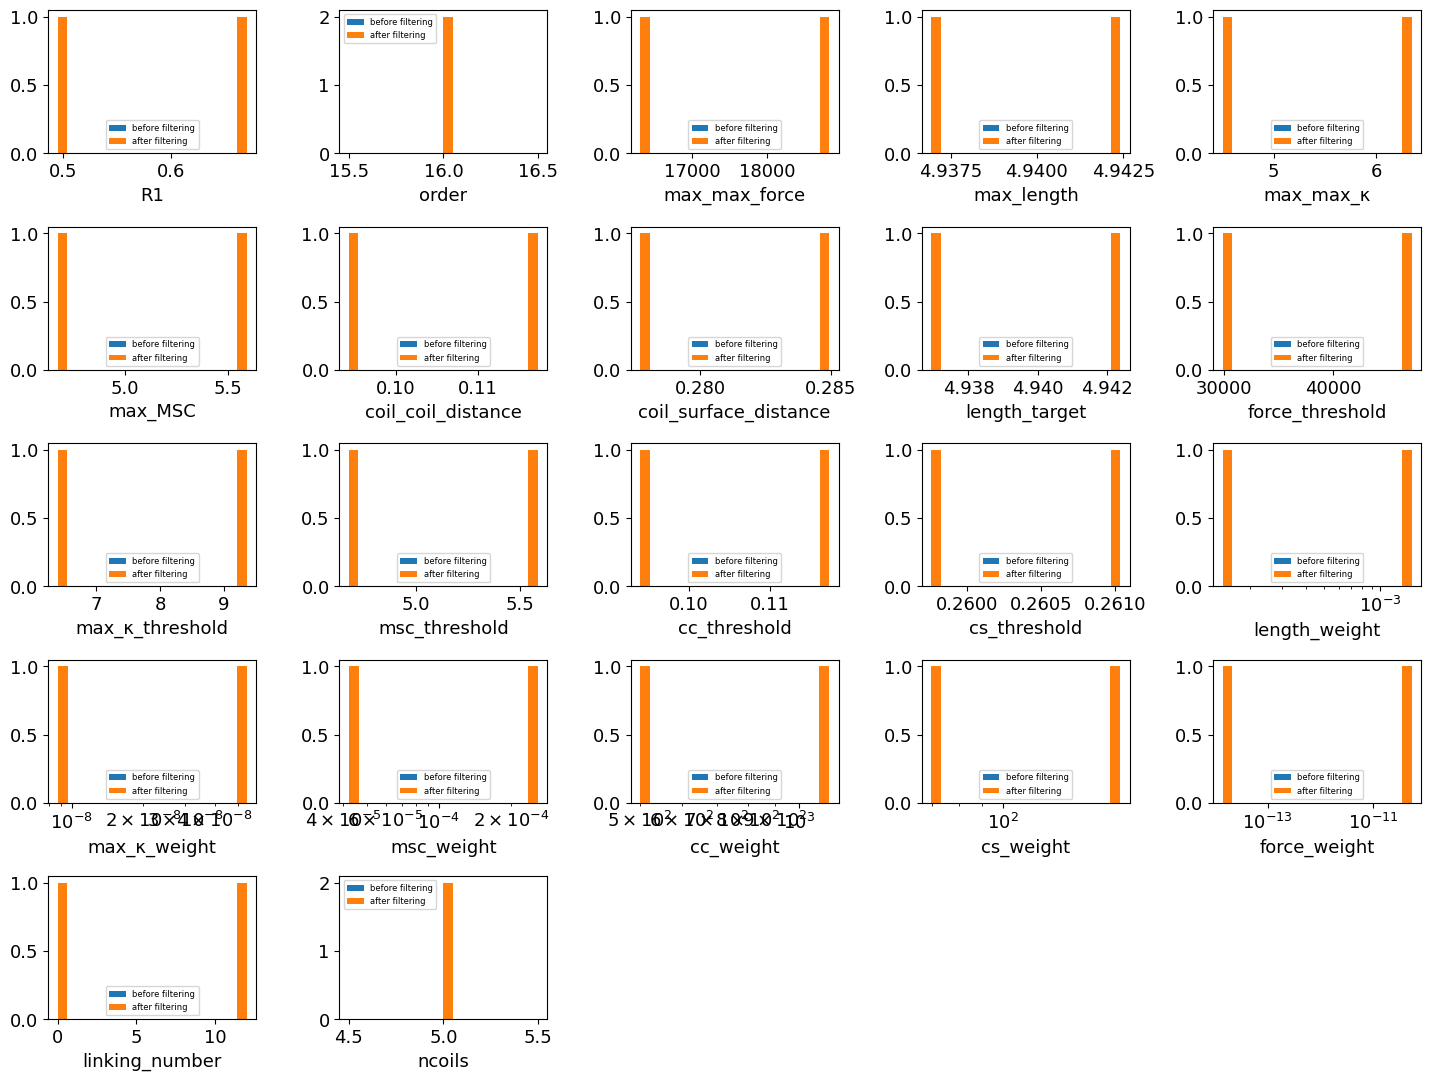

In [8]:
success_plt(df, df_filtered).show()

## Magnetic Field Analysis

Here, we make Poincare plots of the field.

./output/1/poincare/13b5e759418c4d29b5b826acc90f5cb9/
Num steps=60470


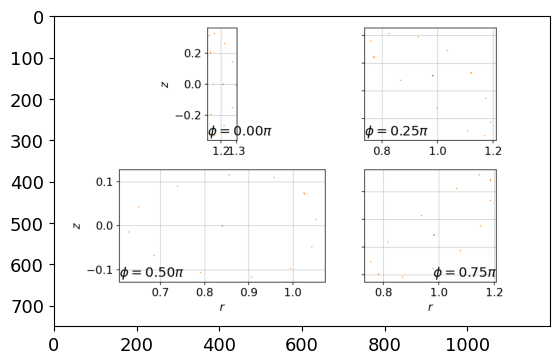

In [9]:
image = poincare('13b5e759418c4d29b5b826acc90f5cb9', OUT_DIR='1/poincare')
plt.imshow(image)